# Understanding Black-Box Chess Agents
This notebook generates saliency maps for a move played by the stockfish engine. The saliency maps give an insight to the tactic behind a particular move.

In [1]:
import chess #version: 0.27.3
import chess.uci
import chess.pgn
import sys
import math
import matplotlib.pyplot as plt
import copy
import cairosvg
import cv2
import time
import numpy as np
import svg_custom.svg_custom as svg_custom # use chess.svg if you don't want the board in B/W

# load your engine:
handler = chess.uci.InfoHandler()
engine = chess.uci.popen_engine('/home/dhruv/rl/stockfish/stockfish-10-linux/Linux/stockfish_10_x64') #give path to your engine here
engine.info_handlers.append(handler)
# board


In [2]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def your_softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def your_entropy(q_vals):
    entropy_q = [i*math.log(i)/math.log(2) for i in q_vals]
    entropy = sum(entropy_q)*-1
    return entropy

def return_q_vals(board, legal_moves, eval_time=100):
    """
    This function calculates Q-values of every move for the given board.
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
    Output:
        q_vals: np array of Q values of required moves
        max_move: chess.Move() - Best move in perturbed state
        second_max_move: chess.Move() - Second best move in perturbed state
        """
    i = 0
    q_vals = []
    
    maxq = -100000000
    second_maxq = -100000000
    max_move = None
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)
    second_max_move = None
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            print(i,'\r',end = '')

            engine.go(searchmoves=[el],movetime=eval_time)
            if handler.info["score"][1].cp is None:
                score = handler.info["score"][1].mate
            else:
                score = round(handler.info["score"][1].cp/100.0,2)
            q_vals.append(score)
            
            if(score > maxq):
                
                second_maxq = maxq
                maxq = score
                
                second_max_move = max_move
                max_move = el
            
            elif(score > second_maxq and score != maxq):
                second_maxq = score
                second_max_move = el

    return np.asarray(q_vals), max_move, second_max_move

def moves_q_vals(board, legal_moves, eval_time, original_move):
    """
    This function returns a dictionary of Q-values for every move.
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
        original_move: original best move (chess.Move()) 
    Output:
        q_vals_dict: Dictionary of move with respective Q-value
        q_vals: np array of Q values of required moves
        max_move: chess.Move() - Best move in perturbed state
        second_max_move: chess.Move() - Second best move in perturbed state
    """
    
    i = 0
    q_vals_dict = {}
    q_vals = []
    
    maxq = -100000000
    second_maxq = -100000000
    max_move = None
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)
    second_max_move = None
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            print(i,'\r',end = '')

            engine.go(searchmoves=[el],movetime=eval_time)
#             score = 0.
            if handler.info["score"][1].cp is None:
                score = handler.info["score"][1].mate
            else:
                score = round(handler.info["score"][1].cp/100.0,2)
            if el != original_move:
                q_vals_dict[el.uci()] = score
            q_vals.append(score)
            if(score > maxq):
                
                second_maxq = maxq
                maxq = score
                
                second_max_move = max_move
                max_move = el
            
            elif(score > second_maxq and score != maxq):
                second_maxq = score
                second_max_move = el

    return q_vals_dict, np.asarray(q_vals), max_move, second_max_move


def heat_policy_atari(dictP, dictQ):
    """
    This function calculates L2-norm of 2 policies
    Input:
        dictP: Policy 1 dictionary of moves with Q-values
        dictQ: Policy 2 dictionary of moves with Q-values
    """
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    dic = dictP.copy()
    dic.update(dictQ)
    for move in dic:
        if move in dictP:
            Q_p.append(dictP[move])
        else:
            Q_p.append(0.)
        if move in dictQ:
            Q_q.append(dictQ[move])
        else:
            Q_q.append(0.)
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    
    S = np.linalg.norm(Q_q - Q_p)

    return S


def cross_entropy(dictP, dictQ):
    """
    This function calculates normalized cross entropy (KL divergence) of Q-values of state Q wrt state P.
    Input:
        dictP: Q-value dictionary of perturbed state
        dictQ: Q-value dictionary of original state
    Output:p = policy[:best_move+1]
    p = np.append(p, policy[best_move+1:])

        K: normalized cross entropy
    """
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    for move in dictP:
        if move in dictQ:
            Q_p.append(dictP[move])
            Q_q.append(dictQ[move])
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    KL = entropy(Q_q, Q_p)
    return (KL)/(KL + 1.)


# Generate saliency maps using our cross-entropy method
We took 15 board positions from lichess.com and explained them using saliency maps. These maps are overlaid onto the chess board for ease of interpretation.

You can load your own board positions (fen notation) by changing board_configs.

**Note: <br>
    Change save path of maps <br>
    This code works for board positions where it is white's turn. See stockfish's evaluation documentation to modify it to work correctly for black's turn**

*********************** queen_trap **********************
Total Legal Moves :  44
Original score (Initial probability of best action):  0.9961753493370736
Original value :  5.55
Best Move is  g2g4
Total Legal Moves :  36
Delta P =  0.9182746944068966
KL normalized =  0.586293251084221
Removed R from position: (0, 4)
------------------------------------------
Total Legal Moves :  43
Delta P =  0.0028744288322254397
KL normalized =  0.10511504671098362
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.9960213423135958
KL normalized =  0.7817394181203374
Removed Q from position: (1, 3)
------------------------------------------
Total Legal Moves :  43
Delta P =  0.8633145922362906
KL normalized =  0.6275753566424334
Removed P from position: (1, 5)
------------------------------------------
Total Legal Moves :  34
Delta P =  0.13318361615659324
KL normalized =  0.6267427409760937
Removed R from position: (2, 0)
-----------------

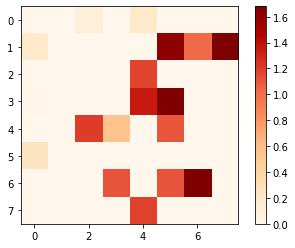

(217, 217, 3)
*********************** queen_fork **********************
Total Legal Moves :  49
Original score (Initial probability of best action):  0.8858802125197552
Original value :  4.42
Best Move is  f4b8
Total Legal Moves :  45
Delta P =  0.0050628122026751265
KL normalized =  0.08925587332756525
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  46
Delta P =  0.04568375442150863
KL normalized =  0.09184916716075178
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  47
Delta P =  -0.03499993742599461
KL normalized =  0.03265394001119832
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  47
Delta P =  -0.06381352984320654
KL normalized =  0.02020270634906565
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  47
Delta P =  -0.038843463532762135
KL normalized =  0.0470219451857625
Removed P from position:

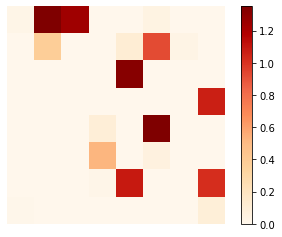

(217, 217, 3)
*********************** bishop_takes_rook **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.8619498914965563
Original value :  3.63
Best Move is  b2g7
Total Legal Moves :  37
Delta P =  0.6740332944665242
KL normalized =  0.6654759878398985
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  36
Delta P =  -0.05663895344790093
KL normalized =  0.33607214862371665
Removed N from position: (0, 1)
------------------------------------------
Total Legal Moves :  33
Delta P =  -0.10358934542740028
KL normalized =  0.36454858982618743
Removed Q from position: (0, 3)
------------------------------------------
Total Legal Moves :  34
Delta P =  0.0038790196950523326
KL normalized =  0.1624005486315478
Removed B from position: (0, 5)
------------------------------------------
Total Legal Moves :  38
Delta P =  -0.02832521646163144
KL normalized =  0.18877462293097746
Removed R from posit

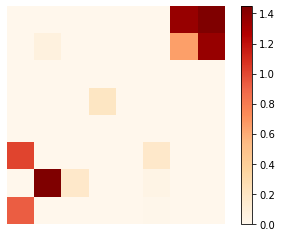

(217, 217, 3)
*********************** pawn_takes_bishop **********************
Total Legal Moves :  32
Original score (Initial probability of best action):  0.780714477999975
Original value :  4.01
Best Move is  f1b1
Total Legal Moves :  30
Delta P =  0.7399666963777359
KL normalized =  0.019508767386298326
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  30
Delta P =  0.25516163334460273
KL normalized =  0.07205643694127857
Removed P from position: (1, 7)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.19169653622466432
KL normalized =  0.04036678540811385
Removed P from position: (2, 3)
------------------------------------------
Total Legal Moves :  31
Delta P =  0.18779312718357355
KL normalized =  0.058928846735465286
Removed P from position: (2, 6)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.7285063301279138
KL normalized =  0.11088852499359077
Removed b from position

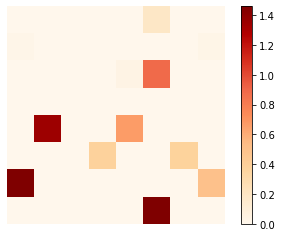

(217, 217, 3)
*********************** showdown **********************
Total Legal Moves :  45
Original score (Initial probability of best action):  0.3236390160253079
Original value :  2.85
Best Move is  d4g7
Total Legal Moves :  44
Delta P =  0.015087384728751485
KL normalized =  0.056953541606208066
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  40
Delta P =  0.25347472797627907
KL normalized =  0.11546329059408679
Removed B from position: (0, 2)
------------------------------------------
Total Legal Moves :  43
Delta P =  -0.031021971394698866
KL normalized =  0.06570477891800836
Removed R from position: (0, 5)
------------------------------------------
Total Legal Moves :  43
Delta P =  -0.011073179408972289
KL normalized =  0.0569885170059738
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  43
Delta P =  -0.0059377388303189504
KL normalized =  0.1791347136437075
Removed P from position:

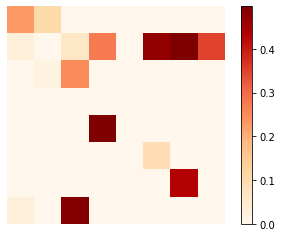

(217, 217, 3)
*********************** rook_captures_queen **********************
Total Legal Moves :  34
Original score (Initial probability of best action):  0.9413680887269692
Original value :  4.74
Best Move is  b4d4
Total Legal Moves :  31
Delta P =  0.3564752243320244
KL normalized =  0.7951814615645544
Removed R from position: (0, 2)
------------------------------------------
Total Legal Moves :  28
Delta P =  -0.0488796217908235
KL normalized =  0.7555632733234302
Removed B from position: (0, 3)
------------------------------------------
Total Legal Moves :  33
Delta P =  -0.012452341163519676
KL normalized =  0.27481984797794196
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.0549318098997259
KL normalized =  0.1686287887942817
Removed P from position: (1, 6)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.056638237868484986
KL normalized =  0.11802243701851584
Removed P from positio

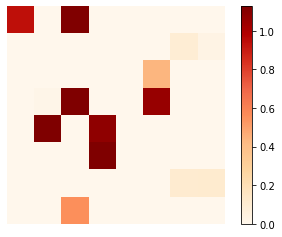

(217, 217, 3)
*********************** knight_captures_queen **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.9964988124413028
Original value :  6.03
Best Move is  a4e4
Total Legal Moves :  34
Delta P =  0.9964321538806272
KL normalized =  0.825944569004654
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.8916089995829912
KL normalized =  0.2692263313498915
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.0025289264308419046
KL normalized =  0.14427705314377237
Removed P from position: (1, 7)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.020141708431838712
KL normalized =  0.17744762902316027
Removed P from position: (2, 0)
------------------------------------------
Total Legal Moves :  33
Delta P =  0.9906670429065626
KL normalized =  0.8439505747597355
Removed N from positi

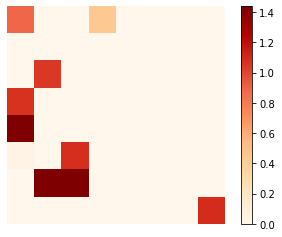

(217, 217, 3)
*********************** rook_up **********************
Total Legal Moves :  40
Original score (Initial probability of best action):  0.9531155034539753
Original value :  5.51
Best Move is  f3e3
Total Legal Moves :  38
Delta P =  -0.021199111917354463
KL normalized =  0.6960225985517123
Removed P from position: (1, 6)
------------------------------------------
Total Legal Moves :  24
Delta P =  0.9113736493495844
KL normalized =  0.6766601658766984
Removed Q from position: (2, 1)
------------------------------------------
Total Legal Moves :  39
Delta P =  -0.0007977343462084452
KL normalized =  0.8526515393952891
Removed P from position: (2, 7)
------------------------------------------
Total Legal Moves :  40
Delta P =  -0.04688449654602467
KL normalized =  0.2536409876532543
Removed r from position: (3, 3)
------------------------------------------
Total Legal Moves :  40
Delta P =  -0.014603439322769418
KL normalized =  0.04105249752502937
Removed p from position: (5, 

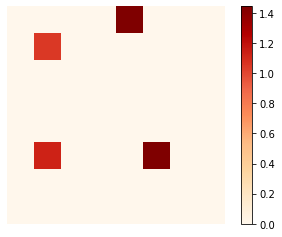

(217, 217, 3)
*********************** queen_exchange **********************
Total Legal Moves :  32
Original score (Initial probability of best action):  0.9939223435781812
Original value :  4.0
Best Move is  g3g4
Total Legal Moves :  30
Delta P =  0.002860034031141656
KL normalized =  0.02009571466080631
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  28
Delta P =  0.050436069864230326
KL normalized =  0.16300975538736792
Removed R from position: (0, 2)
------------------------------------------
Total Legal Moves :  30
Delta P =  0.13135531073857842
KL normalized =  0.05673780573882322
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  31
Delta P =  0.13337806285378662
KL normalized =  0.4262239037373534
Removed N from position: (1, 4)
------------------------------------------
Total Legal Moves :  25
Delta P =  0.09842917324246148
KL normalized =  0.002714982808755173
Removed P from position:

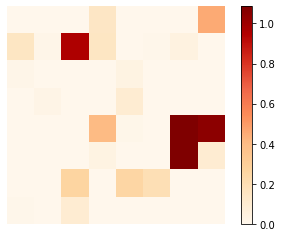

(217, 217, 3)
*********************** discover_attack **********************
Total Legal Moves :  29
Original score (Initial probability of best action):  0.9951235264606666
Original value :  6.3
Best Move is  c2b2
Total Legal Moves :  11
Delta P =  0.9951234395991081
KL normalized =  0.10486626058490274
Removed Q from position: (0, 6)
------------------------------------------
Total Legal Moves :  26
Delta P =  0.7382924622922111
KL normalized =  0.5978420798882514
Removed N from position: (1, 4)
------------------------------------------
Total Legal Moves :  27
Delta P =  0.013148729797489267
KL normalized =  0.2741768533731761
Removed P from position: (1, 7)
------------------------------------------
Total Legal Moves :  29
Delta P =  0.045394812588432476
KL normalized =  0.807530679669118
Removed q from position: (2, 0)
------------------------------------------
Total Legal Moves :  28
Delta P =  0.94622173754601
KL normalized =  0.28067747054780273
Removed P from position: (2, 2)


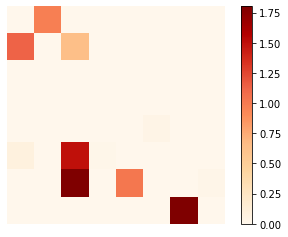

(217, 217, 3)
*********************** standoff **********************
Total Legal Moves :  38
Original score (Initial probability of best action):  0.9787670136205893
Original value :  5.25
Best Move is  d2f4
Total Legal Moves :  31
Delta P =  0.9762762920113325
KL normalized =  0.834560158171268
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  34
Delta P =  0.7048654244388934
KL normalized =  0.6008420995423065
Removed N from position: (1, 5)
------------------------------------------
Total Legal Moves :  36
Delta P =  0.2172373431776643
KL normalized =  0.14082121065868358
Removed P from position: (1, 6)
------------------------------------------
Total Legal Moves :  38
Delta P =  0.05453481963553042
KL normalized =  0.870041178263324
Removed q from position: (2, 0)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.021231280923906026
KL normalized =  0.811400157129981
Removed b from position: (2, 1)
-------

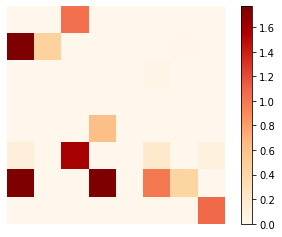

(217, 217, 3)
*********************** rook_takes_bishop **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.8248642022015809
Original value :  5.41
Best Move is  d2d7
Total Legal Moves :  34
Delta P =  0.8247688682366083
KL normalized =  0.367666604129401
Removed R from position: (0, 3)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.14232265030110713
KL normalized =  0.057312866070487474
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.751243874491692
KL normalized =  0.35763228129265007
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  39
Delta P =  -0.004954538332889613
KL normalized =  0.05099925932084195
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  35
Delta P =  0.28044658452916027
KL normalized =  0.053500932247650256
Removed Q from positio

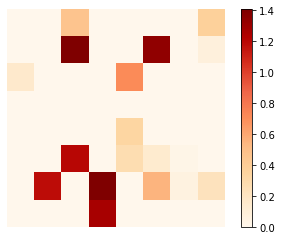

(217, 217, 3)
*********************** bishop_takes_queen **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.9924220766684823
Original value :  4.44
Best Move is  e1e5
Total Legal Moves :  35
Delta P =  0.9923736355226968
KL normalized =  0.950047394144059
Removed R from position: (0, 3)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.0023546370065371525
KL normalized =  0.002962842243560813
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.002055676916136062
KL normalized =  0.03093138660722322
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.6978352516966929
KL normalized =  0.01611063342171303
Removed P from position: (1, 5)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.004931232782616091
KL normalized =  0.0028310864691065197
Removed P from po

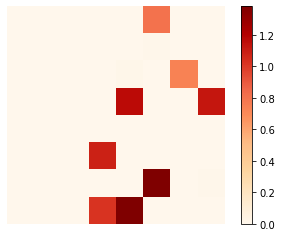

(217, 217, 3)
*********************** bishop_up **********************
Total Legal Moves :  41
Original score (Initial probability of best action):  0.8999277473742446
Original value :  5.48
Best Move is  e4c5
Total Legal Moves :  40
Delta P =  0.0023443475283416726
KL normalized =  0.05479139247118374
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.01625531429092264
KL normalized =  0.059754361958620675
Removed B from position: (0, 2)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.13128421277889035
KL normalized =  0.047698935706424715
Removed R from position: (0, 5)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.004294787148723445
KL normalized =  0.05979247270143767
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.09808664075375462
KL normalized =  0.10056055188648784
Removed P from position: 

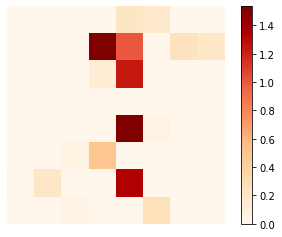

(217, 217, 3)
*********************** bishop_fork **********************
Total Legal Moves :  43
Original score (Initial probability of best action):  0.9977842309401852
Original value :  5.0
Best Move is  c5b6
Total Legal Moves :  38
Delta P =  0.0041435826261391195
KL normalized =  0.047577462789946644
Removed R from position: (0, 2)
------------------------------------------
Total Legal Moves :  33
Delta P =  0.03741718523959403
KL normalized =  0.3814715019407411
Removed Q from position: (0, 3)
------------------------------------------
Total Legal Moves :  42
Delta P =  0.003548577940772124
KL normalized =  0.12261175594947928
Removed R from position: (0, 5)
------------------------------------------
Total Legal Moves :  42
Delta P =  0.0003440210205162275
KL normalized =  0.04699248099737812
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.0008781509988171621
KL normalized =  0.07578230995951112
Removed B from positio

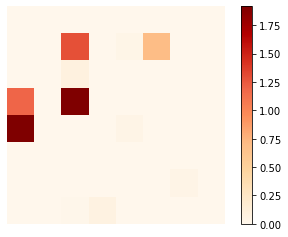

(217, 217, 3)


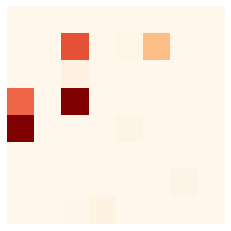

In [3]:
######################## heatmaps for cross entropy method
    
board_configs = {}
board_configs['queen_trap'] = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'
board_configs['queen_fork'] = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1'
board_configs['bishop_takes_rook'] = 'rnbqk1nr/1p3ppp/4p3/2bp4/8/p3PN2/1BP2PPP/RN1QKB1R w - - 0 1'
board_configs['pawn_takes_bishop'] = '1k3r2/p6p/2p1Bp2/4p3/1b1pP3/3P2P1/P1K4P/5R2 w - - 0 1'
board_configs['showdown'] = 'rn1qk1nr/p1pp1ppp/1pb1p3/8/2BQ4/2P2N2/PPP2PPP/R1B2RK1 w - - 0 1'
board_configs['rook_captures_queen'] = 'r1r5/2k3pp/2p2p2/1pR1pq2/PQ1n4/3P4/1P4PP/1KRB4 w - - 0 1'
board_configs['knight_captures_queen'] = 'r2r4/1kp2p1p/1q2b1p1/R7/Q7/P1N5/1PP4P/1K5R w - - 0 1'
board_configs['rook_up'] = '4r1k1/1R4p1/4qp1p/8/3r4/1Q3R1P/6P1/7K w - - 0 1'
board_configs['queen_exchange'] = '2kr3r/bbqp1pp1/p3p3/1p2n3/1P1NPBnp/P2B2QP/2P1NPP1/R1R3K1 w - - 0 1'
board_configs['discover_attack'] = '1r6/pkp2p1p/5b2/5p2/5P2/q1PP4/2R1N2P/1K4Q1 w - - 0 1'
board_configs['standoff'] = '1kr5/pr4p1/5n1p/5p2/3P4/qbR2P1P/B2Q1NP1/K6R w - - 0 1'
board_configs['rook_takes_bishop'] = '1kr2b1r/1pq2bpp/p3np2/2p1p3/4P3/2N1BPN1/PPPR1QPP/1K1R4 w - - 0 1'
board_configs['bishop_takes_queen'] = '5rk1/p1q2ppp/1p2p1n1/2p1r2Q/2P5/3B4/PP3PPP/3RR1K1 w - - 0 1'
board_configs['bishop_up'] = '4rrk1/pp1qp1bp/2pnbpp1/8/3PNP2/2PB4/PP2Q1PP/R1B2RK1 w - - 0 1'
board_configs['bishop_fork'] = '2b1r1k1/2q1bppp/2p3n1/r1B1p3/N3n3/5N2/P3BPPP/2RQ1RK1 w - - 0 1'

for board_name in board_configs:
    print("***********************", board_name, "**********************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    evaltime = 100
    
    # set original state 
    engine.position(board)
    evaluation = engine.go(movetime=evaltime)
    original_move = evaluation.bestmove

    legal_moves = list(board.legal_moves)[:]

    
    # Q-values for original state
    q_vals_dict_og, q_vals, _,second_best_move  = moves_q_vals(board, legal_moves, evaltime, original_move)

    q_old = np.max(q_vals)

    
    # probability of original_move in original state
    old_score = np.exp(max(q_vals))/np.sum(np.exp(q_vals))

    # policy of original state
#     softmax = your_softmax(q_vals)
#     entropy_og = entropy(softmax)

    print("Original score (Initial probability of best action): ", old_score)
    print("Original value : ", max(q_vals))
    print("Best Move is ", original_move)
    heatmap = np.zeros((8, 8))
#     entropy_map = np.zeros((8,8))

    for i in range(64):
        h = i//8 
        w = i%8
        
        # perturb board
        piece_removed = board.remove_piece_at(i)

        # Evaluate the board on the basis of the value
        if piece_removed is not None:

            # If king is removed or if board position is illegal set it back 
            if (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
                board.set_piece_at(i, piece_removed)
            else:
                # set perturbed state
                engine.position(board)

                # Check if the original move is still valid
                if board.is_legal(original_move):

                    # Find the index of the original move in the list of legal moves
                    j = 0
                    original_move_index = 0
                    for el in legal_moves:
                        if el in board.legal_moves:
                            if(el == original_move):
                                original_move_index = j
                            j+=1

                    # Find the q values 
                    q_vals_dict_new, q_vals, new_best_move, new_second_best_move = moves_q_vals(board, legal_moves, evaltime, original_move)

                    # probability of original move in perturbed state
                    new_score = np.exp(q_vals[original_move_index])/np.sum(np.exp(q_vals))

                    new_q = q_vals[original_move_index]

                    K = cross_entropy(q_vals_dict_new, q_vals_dict_og)

                    dP = old_score - new_score

                    if new_score < old_score: # harmonic mean
                        heatmap[h, w] = 2*dP/(1 + dP*K)
                    else:
                        heatmap[h, w] = 0.

                    print("Delta P = ", dP)
                    print("KL normalized = ", K)
                    print('Removed', piece_removed, 'from position:', (h, w))
                    print('------------------------------------------')
                
                else:
                    # illegal original move in perturbed state
                    heatmap[h, w] = -1.

                # undo perturbation
                board.set_piece_at(i, piece_removed)

    heatmap = np.flipud(heatmap)
    
    
    # If original move is not valid, give highest value in the heat map
    heatmap[heatmap == -1] = np.max(heatmap)
    
    
    
    ### Original Saliency Map (without overlay onto board)
    
    plt.figure(1)
    plt.imshow(heatmap, cmap='OrRd')
    plt.colorbar()
    plt.savefig('results/entropy/map_'+board_name+'.png')
    plt.show()    


    #### Saliency map overlaid on board
    
    svg = svg_custom.board(board) 
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')

    # original board as a numpy array
    board_array = cv2.imread('board.png')

    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(heatmap, cmap='OrRd')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('/tmp/test.png', bbox_inches='tight', pad_inches=0)

    img = cv2.imread('/tmp/test.png')
    print(img.shape) # should be 400x400 for overlay to be correct

    threshold = 200 # grayscale threshold for saliency. Saliency values above this threshold won't be mapped onto board
    
    n = board_array.shape[0]
    m = board_array.shape[1]
    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            color_i = i*27 + 13
            color_j = j*27 + 13
            ii = 45*i+20
            jj = 45*j+20
            grayscale = 0.299*img[color_i, color_j][2] + 0.587*img[color_i, color_j][1] + 0.114*img[color_i, color_j][0]
            if grayscale > threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j] = img[color_i, color_j]


    cv2.imwrite("results/entropy/" + board_name + ".png",board_array)


# Generate Saliency Maps using other methods


*************************queen_trap*****************************
Original value :  5.39
-----------------------------
Position :  0 2
Piece :  r
New Action Value :  12.89
New State Value :  13.01
-----------------------------
Position :  0 4
Piece :  r
New Action Value :  12.61
New State Value :  13.1
-----------------------------
Position :  1 0
Piece :  b
New Action Value :  9.76
New State Value :  9.88
-----------------------------
Position :  1 5
Piece :  p
New Action Value :  0.09
New State Value :  0.58
-----------------------------
Position :  1 6
Piece :  p
New Action Value :  8.5
New State Value :  9.67
-----------------------------
Position :  1 7
Piece :  p
New Action Value :  -2.36
New State Value :  1.44
-----------------------------
Position :  2 0
Piece :  p
New Action Value :  7.39
New State Value :  7.4
-----------------------------
Position :  2 4
Piece :  p
New Action Value :  -1.97
New State Value :  -0.89
-----------------------------
Position :  3 0
Piece :  P
New

/home/dhruv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/dhruv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(217, 217, 3)
(217, 217, 3)
*************************queen_fork*****************************
Original value :  4.48
-----------------------------
Position :  0 0
Piece :  r
New Action Value :  11.0
New State Value :  11.05
-----------------------------
Position :  0 1
Piece :  n
New Action Value :  4.47
New State Value :  6.05
-----------------------------
Position :  0 2
Piece :  b
New Action Value :  5.21
New State Value :  5.78
-----------------------------
Position :  0 3
Piece :  q
New Action Value :  17.73
New State Value :  17.81
-----------------------------
Position :  0 5
Piece :  r
New Action Value :  10.82
New State Value :  10.84
-----------------------------
Position :  1 0
Piece :  p
New Action Value :  5.09
New State Value :  4.91
-----------------------------
Position :  1 1
Piece :  p
New Action Value :  4.38
New State Value :  4.11
-----------------------------
Position :  1 4
Piece :  b
New Action Value :  9.82
New State Value :  9.76
-----------------------------
P

New Action Value :  4.37
New State Value :  4.49
-----------------------------
Position :  1 3
Piece :  p
New Action Value :  3.2
New State Value :  3.99
-----------------------------
Position :  1 5
Piece :  p
New Action Value :  3.69
New State Value :  5.02
-----------------------------
Position :  1 6
Piece :  p
New Action Value :  3.05
New State Value :  14.04
-----------------------------
Position :  1 7
Piece :  p
New Action Value :  2.13
New State Value :  2.12
-----------------------------
Position :  2 1
Piece :  p
New Action Value :  4.39
New State Value :  4.35
-----------------------------
Position :  2 2
Piece :  b
New Action Value :  8.66
New State Value :  7.75
-----------------------------
Position :  2 4
Piece :  p
New Action Value :  13.99
New State Value :  14.35
-----------------------------
Position :  4 2
Piece :  B
New Action Value :  -2.4
New State Value :  -2.43
-----------------------------
Position :  5 2
Piece :  P
New Action Value :  1.62
New State Value : 

New Action Value :  1.58
New State Value :  1.59
-----------------------------
Position :  4 5
Piece :  B
New Action Value :  -10.26
New State Value :  -5.62
-----------------------------
Position :  4 6
Piece :  n
New Action Value :  4.03
New State Value :  7.38
-----------------------------
Position :  4 7
Piece :  p
New Action Value :  5.01
New State Value :  8.18
-----------------------------
Position :  5 0
Piece :  P
New Action Value :  3.5
New State Value :  3.59
-----------------------------
Position :  5 3
Piece :  B
New Action Value :  -1.96
New State Value :  -2.32
-----------------------------
Position :  5 7
Piece :  P
New Action Value :  -2.65
New State Value :  -2.27
-----------------------------
Position :  6 2
Piece :  P
New Action Value :  8.57
New State Value :  8.62
-----------------------------
Position :  6 4
Piece :  N
New Action Value :  -5.3
New State Value :  -6.06
-----------------------------
Position :  6 5
Piece :  P
New Action Value :  -0.36
New State Val

New Action Value :  5.44
New State Value :  5.46
-----------------------------
Position :  2 1
Piece :  p
New Action Value :  5.75
New State Value :  5.95
-----------------------------
Position :  2 4
Piece :  p
New Action Value :  5.5
New State Value :  5.45
-----------------------------
Position :  2 6
Piece :  n
New Action Value :  10.27
New State Value :  1
-----------------------------
Position :  3 2
Piece :  p
New Action Value :  5.65
New State Value :  5.75
-----------------------------
Position :  3 4
Piece :  r
New Action Value :  4.29
New State Value :  7.98
-----------------------------
Position :  3 7
Piece :  Q
New Action Value :  -16.29
New State Value :  -14.4
-----------------------------
Position :  4 2
Piece :  P
New Action Value :  3.45
New State Value :  3.4
-----------------------------
Position :  5 3
Piece :  B
New Action Value :  -6.6
New State Value :  -6.74
-----------------------------
Position :  6 0
Piece :  P
New Action Value :  3.11
New State Value :  3.

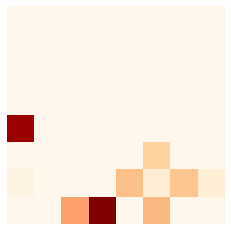

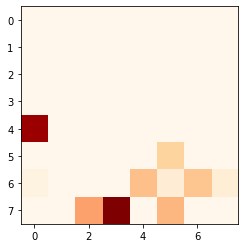

In [4]:
######################## heatmaps for other comparison methods

for board_name in board_configs:
    print("*************************" + board_name + "*****************************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    handler = chess.uci.InfoHandler()
    engine = chess.uci.popen_engine('/home/dhruv/rl/stockfish/stockfish-10-linux/Linux/stockfish_10_x64') #give correct address of your engine here
    engine.info_handlers.append(handler)
    
    engine.position(board)
    evaltime = 100 
    best_evaluation = engine.go(movetime=evaltime)
    
    # V of original state (This is also Q(original state, best action))
    V = handler.info["score"][1].cp/100.0
    move_to_take = [best_evaluation[0]]
    print("Original value : ", V)
    
    # V-based method
    heatmap = np.zeros((8,8))
    # Q-based method
    heatmapQ = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):
            pos = 8*(7-i) + j
            #perturb board
            piece = board.remove_piece_at(pos)
            
            if piece is None or piece.piece_type is 6 or board.was_into_check() or board.is_legal(move_to_take[0]) is False:
                heatmap[i][j] = 0.
                heatmapQ[i, j] = 0.
            else:
                print("-----------------------------")
                print("Position : ", i, j)
                print("Piece : ", piece)
                
                engine.position(board)
                p_evaluation = engine.go(searchmoves=move_to_take, movetime=evaltime)
                # Q for original move in perturbed state
                if handler.info["score"][1].cp is None:
                    p_Q = handler.info["score"][1].mate
                else:
                    p_Q = handler.info["score"][1].cp/100.0
                
                
                engine.position(board)
                p_evaluation = engine.go(movetime=evaltime)
                # V of perturbed_state
                if handler.info["score"][1].cp is None:
                    p_V = handler.info["score"][1].mate
                else:
                    p_V = handler.info["score"][1].cp/100.0
                print("New Action Value : ", p_Q)
                print("New State Value : ", p_V)
                heatmap[i][j] = pow(V - p_V,2)*0.5
                heatmapQ[i, j] = max(V - p_Q, 0)
                
            board.set_piece_at(pos, piece)
    
    
    
##### Original Saliency maps
    
    plt.figure(1)
    plt.imshow(heatmap, cmap='OrRd')
    plt.savefig('results/value_l2/V_map_' + board_name + '.png')
    
    plt.figure(2)
    plt.imshow(heatmapQ, cmap='OrRd')
    plt.savefig('results/action_value/Q_map_' + board_name + '.png')
    
    
##### Saliency maps on the chess board    
    
    ########## Saving 0.5*(V1 - V2)**2
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(heatmap, cmap='OrRd')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('/tmp/test.png', bbox_inches='tight', pad_inches=0)

    img = cv2.imread('/tmp/test.png')
    print(img.shape)

    n = board_array.shape[0]
    m = board_array.shape[1]
    color_threshold = 200
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            color_i = i*27 + 13
            color_j = j*27 + 13
            ii = 45*i+20
            jj = 45*j+20
            grayscale = 0.299*img[color_i, color_j][2] + 0.587*img[color_i, color_j][1] + 0.114*img[color_i, color_j][0]
            if grayscale > 200:
                continue

            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j] = img[color_i, color_j]

    cv2.imwrite("results/value_l2/V_" + board_name + ".png" ,board_array)
    
    
    ############# Saving Q2 - Q1
    
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(heatmapQ, cmap='OrRd')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('/tmp/test.png', bbox_inches='tight', pad_inches=0)

    img = cv2.imread('/tmp/test.png')
    print(img.shape)


    n = board_array.shape[0]
    m = board_array.shape[1]
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            color_i = i*27 + 13
            color_j = j*27 + 13
            ii = 45*i+20
            jj = 45*j+20
            grayscale = 0.299*img[color_i, color_j][2] + 0.587*img[color_i, color_j][1] + 0.114*img[color_i, color_j][0]
            if grayscale > 200:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j] = img[color_i, color_j]
    

    cv2.imwrite("results/action_value/Q_" + board_name + ".png" ,board_array)
    

*********************** queen_trap **********************
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  36
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  43
Total Legal Moves :  39
Total Legal Moves :  34
Total Legal Moves :  43
Total Legal Moves :  37
Total Legal Moves :  43
Total Legal Moves :  36


/home/dhruv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/dhruv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:148: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(217, 217, 3)
*********************** queen_fork **********************
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  42
Total Legal Moves :  45
Total Legal Moves :  47
Total Legal Moves :  47
Total Legal Moves :  47
Total Legal Moves :  44
Total Legal Moves :  43
Total Legal Moves :  49
Total Legal Moves :  47
Total Legal Moves :  47
Total Legal Moves :  45
Total Legal Moves :  46
(217, 217, 3)
*********************** bishop_takes_rook **********************
Total Legal Moves :  39
Total Legal Moves :  39
Total Legal Moves :  39
Total Legal Moves :  39
Total Legal Moves :  39
Total Legal Moves :  39
Total Legal Moves :  39
Total Leg

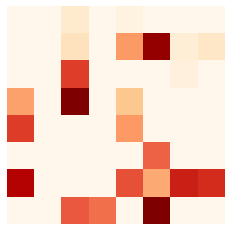

In [5]:
def heat(dictP, dictQ):
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    dic = dictP.copy()
    dic.update(dictQ)
    for move in dic:
        if move in dictP:
            Q_p.append(dictP[move])
        else:
            Q_p.append(0.)
        if move in dictQ:
            Q_q.append(dictQ[move])
        else:
            Q_q.append(0.)
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    
    S = np.linalg.norm(Q_q - Q_p)

    return S

board_configs = {}
board_configs['queen_trap'] = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'
board_configs['queen_fork'] = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1'
board_configs['bishop_takes_rook'] = 'rnbqk1nr/1p3ppp/4p3/2bp4/8/p3PN2/1BP2PPP/RN1QKB1R w - - 0 1'
board_configs['pawn_takes_bishop'] = '1k3r2/p6p/2p1Bp2/4p3/1b1pP3/3P2P1/P1K4P/5R2 w - - 0 1'
board_configs['showdown'] = 'rn1qk1nr/p1pp1ppp/1pb1p3/8/2BQ4/2P2N2/PPP2PPP/R1B2RK1 w - - 0 1'
board_configs['rook_captures_queen'] = 'r1r5/2k3pp/2p2p2/1pR1pq2/PQ1n4/3P4/1P4PP/1KRB4 w - - 0 1'
board_configs['knight_captures_queen'] = 'r2r4/1kp2p1p/1q2b1p1/R7/Q7/P1N5/1PP4P/1K5R w - - 0 1'
board_configs['rook_up'] = '4r1k1/1R4p1/4qp1p/8/3r4/1Q3R1P/6P1/7K w - - 0 1'
board_configs['queen_exchange'] = '2kr3r/bbqp1pp1/p3p3/1p2n3/1P1NPBnp/P2B2QP/2P1NPP1/R1R3K1 w - - 0 1'
board_configs['discover_attack'] = '1r6/pkp2p1p/5b2/5p2/5P2/q1PP4/2R1N2P/1K4Q1 w - - 0 1'
board_configs['standoff'] = '1kr5/pr4p1/5n1p/5p2/3P4/qbR2P1P/B2Q1NP1/K6R w - - 0 1'
board_configs['rook_takes_bishop'] = '1kr2b1r/1pq2bpp/p3np2/2p1p3/4P3/2N1BPN1/PPPR1QPP/1K1R4 w - - 0 1'
board_configs['bishop_takes_queen'] = '5rk1/p1q2ppp/1p2p1n1/2p1r2Q/2P5/3B4/PP3PPP/3RR1K1 w - - 0 1'
board_configs['bishop_up'] = '4rrk1/pp1qp1bp/2pnbpp1/8/3PNP2/2PB4/PP2Q1PP/R1B2RK1 w - - 0 1'
board_configs['bishop_fork'] = '2b1r1k1/2q1bppp/2p3n1/r1B1p3/N3n3/5N2/P3BPPP/2RQ1RK1 w - - 0 1'

for board_name in board_configs:
    print("***********************", board_name, "**********************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    evaltime = 100
    
    # set original state 
    engine.position(board)
    evaluation = engine.go(movetime=evaltime)
    original_move = evaluation.bestmove

    legal_moves = list(board.legal_moves)[:]

    
    # Q-values for original state
    q_vals_dict_og, q_vals, _,second_best_move  = moves_q_vals(board, legal_moves, evaltime, original_move)

    old_V = np.max(q_vals)

    
    # probability of original_move in original state
    old_score = np.exp(max(q_vals))/np.sum(np.exp(q_vals))

    heatmapV = np.zeros((8, 8))
    heatmapP = np.zeros((8, 8))

    for h in range(8):
        for w in range(8):
        # perturb board
            pos = 8*(7-h) + w
            piece_removed = board.remove_piece_at(pos)

            # Evaluate the board on the basis of the value
            if piece_removed is not None:

                # If king is removed or if board position is illegal set it back 
                if (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
                    board.set_piece_at(pos, piece_removed)
                else:
                    # set perturbed state
                    engine.position(board)

                    # Check if the original move is still valid
                    if board.is_legal(original_move):

                        # Find the index of the original move in the list of legal moves
                        j = 0
                        original_move_index = 0
                        for el in legal_moves:
                            if el in board.legal_moves:
                                if(el == original_move):
                                    original_move_index = j
                                j+=1

                        # Find the q values 
                        q_vals_dict_new, q_vals, new_best_move, new_second_best_move = moves_q_vals(board, legal_moves, evaltime, original_move)

                        # probability of original move in perturbed state
                        new_score = np.exp(q_vals[original_move_index])/np.sum(np.exp(q_vals))

                        new_q = q_vals[original_move_index]
                         
                        new_V = np.max(np.asarray(q_vals))

                        K = heat(q_vals_dict_new, q_vals_dict_og)
                        heatmapV[h,w] = 0.5*(old_V - new_V)**2
                        heatmapP[h, w] = K

                    else:
                        # illegal original move in perturbed state
                        heatmapP[h, w] = -1.
                        heatmapV[h, w] = -1
                    # undo perturbation
                    board.set_piece_at(pos, piece_removed)


    # If original move is not valid, give highest value in the heat map
    heatmapV[heatmapV == -1] = np.max(heatmapV)
    heatmapP[heatmapP == -1] = np.max(heatmapP)

#     heatmap = np.zeros((8,8,3))
#     heatmapV = (heatmapV - np.min(heatmapV))/(np.max(heatmapV) - np.min(heatmapV))
#     heatmapP = (heatmapP - np.min(heatmapP))/(np.max(heatmapP) - np.min(heatmapP))
#     heatmap = np.zeros((8,8))
#     heatmap[heatmapV >= heatmapP] = heatmapV + heatmapP
#     heatmap[heatmapV < heatmapP] = -1.0*(heatmapV + heatmapP)
    
    plt.figure(1)
    plt.imshow(heatmapP, cmap='OrRd')
    plt.savefig('results/value_l2/policy_map_' + board_name + '.png')
    
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(heatmapV, cmap='OrRd')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('/tmp/test.png', bbox_inches='tight', pad_inches=0)

    imgV = cv2.imread('/tmp/test.png')
    
    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(heatmapP, cmap='OrRd')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('/tmp/test.png', bbox_inches='tight', pad_inches=0)

    img = cv2.imread('/tmp/test.png')

    
#     img = cv2.addWeighted(imgP,0.5,imgV,0.5,0)
  
    print(img.shape)
    
    n = board_array.shape[0]
    m = board_array.shape[1]
    color_threshold = 200
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            color_i = i*27 + 13
            color_j = j*27 + 13
            ii = 45*i+20
            jj = 45*j+20

            grayscale = 0.299*img[color_i, color_j][2] + 0.587*img[color_i, color_j][1] + 0.114*img[color_i, color_j][0]
            if grayscale > 200:
                continue

            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    
                    board_array[box_i, box_j] = img[color_i, color_j]

    cv2.imwrite("results/value_l2/policy_" + board_name + ".png" ,board_array)
#     break
    
    